<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Check-with-GUI-meshing" data-toc-modified-id="Check-with-GUI-meshing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Check with GUI meshing</a></span></li></ul></div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.ERROR)
logging.root.setLevel('INFO')
import io
import pandas as pd
import geopandas as gpd
import numpy as np
import fiona as fio
import rasterio as rio
import shapely.geometry as sg
import zipfile
import requests
from pathlib import Path
import subprocess
import folium
import requests
import rasterio.plot
import matplotlib.pyplot as plt
import rasterio.plot
import descartes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path


CWD = Path('.').resolve()
OUT_PATH = CWD / '00_input_data'
OUT_PATH.mkdir(exist_ok=True)

import sys
sys.path.append(str(CWD.parent / 'python_lib'))
sys.path

import dotenv
dotenv.load_dotenv()
print(dotenv.load_dotenv(CWD.parent))
import os

DATA_PATH = CWD / '00_input_data'
TEST_CASE_PATH = Path('.').resolve()
SIM_PATH = TEST_CASE_PATH / '01_simulation_resolution_50m_no_grading'
SIM_PATH.mkdir(exist_ok=True)
COMPUTATION_PATH = SIM_PATH / 'Computation'
COMPUTATION_PATH.mkdir(exist_ok=True)

True


# Check with GUI meshing

In [2]:
from mesher import GrammMesher
from_gui_path = SIM_PATH.parent.parent.parent / 'GRAMM_Mesher' / 'test' / 'Askervein_50m'
from_gui = GrammMesher.read_mesh(from_gui_path / 'ggeom.asc')
from_gui.read_landuse(from_gui_path / 'landuse.asc')

from_py = GrammMesher.read_mesh(SIM_PATH / 'Computation' / 'ggeom.asc')
from_py.read_landuse(SIM_PATH / 'Computation' / 'landuse.asc')

/usr/local/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [3]:
ATTRS = [
    'AH',
    'AHE',
    'AREAX',
    'AREAY',
    'AREAZ',
    'AREAZX',
    'AREAZY',
    'DDX',
    'DDY',
    'VOL',
    'X',
    'Y',
    'Z',
    'ZAX',
    'ZAY',
    'ZSP',
    'ddz',
    'dz0',
    'nx',
    'ny',
    'nz',
    'xmax',
    'xmin',
    'ymax',
    'ymin'
]

precision = 2
for attr in ATTRS:
    a = getattr(from_gui, attr)
    b = getattr(from_py, attr)
    a = np.round(a, precision)
    b = np.round(b, precision)    
    delta = np.round(np.max(np.abs(a - b)), precision)  
    if delta > 10**-precision:
        logging.warn(f"{attr} failed (delta={delta})")
    else:
        logging.info(f"{attr} passed")
delta

INFO:root:AH passed
INFO:root:AHE passed
INFO:root:AREAX passed
INFO:root:AREAY passed
INFO:root:AREAZ passed
INFO:root:AREAZX passed
INFO:root:AREAZY passed
INFO:root:DDX passed
INFO:root:DDY passed
INFO:root:VOL passed
INFO:root:X passed
INFO:root:Y passed
INFO:root:Z passed
INFO:root:ZAX passed
INFO:root:ZAY passed
INFO:root:ZSP passed
INFO:root:ddz passed
INFO:root:dz0 passed
INFO:root:nx passed
INFO:root:ny passed
INFO:root:nz passed
INFO:root:xmax passed
INFO:root:xmin passed
INFO:root:ymax passed
INFO:root:ymin passed


0

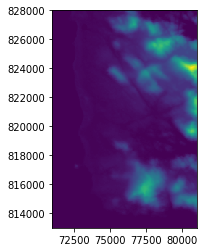

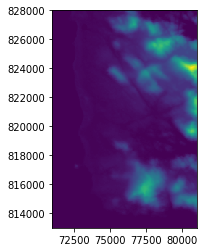

In [4]:
import vtk
from vtk.util.numpy_support import numpy_to_vtk, vtk_to_numpy
plt.pcolormesh(
    from_py.xmin + from_py.X,
    from_py.ymin + from_py.Y, 
    vtk_to_numpy(
        from_py.terrain_grid.GetPointData().GetArray('Elevation')
    ).reshape(from_py.ny+1, from_py.nx+1, order='C')
)
plt.gca().set_aspect("equal");

plt.figure()
plt.pcolormesh(
    from_gui.xmin + from_gui.X,
    from_gui.ymin + from_gui.Y, 
    vtk_to_numpy(
        from_gui.terrain_grid.GetPointData().GetArray('Elevation')
    ).reshape(from_gui.ny+1, from_gui.nx+1, order='C')
)
plt.gca().set_aspect("equal")

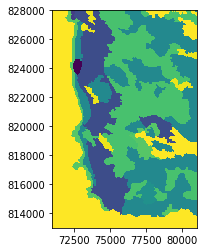

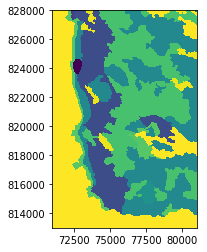

In [5]:
import vtk
from vtk.util.numpy_support import numpy_to_vtk, vtk_to_numpy
plt.pcolormesh(
    from_py.xmin + from_py.X,
    from_py.ymin + from_py.Y, 
    vtk_to_numpy(
        from_py.terrain_grid.GetCellData().GetArray('CLC')
    ).reshape(from_py.ny, from_py.nx, order='C')
)
plt.gca().set_aspect("equal");

plt.figure()
plt.pcolormesh(
    from_gui.xmin + from_gui.X,
    from_gui.ymin + from_gui.Y, 
    vtk_to_numpy(
        from_gui.terrain_grid.GetCellData().GetArray('CLC')
    ).reshape(from_gui.ny, from_gui.nx, order='C')
)
plt.gca().set_aspect("equal")

In [6]:
def get_nb_url(port=None):
    import notebook
    import notebook.notebookapp
    import re
    import json
    import logging
    
    nb_server = next(notebook.notebookapp.list_running_servers())
    
    if port is None:        
        port = int(nb_server['port'])
        
    kernel_id = None
    try:
        kernel_id = re.search("kernel-(.*).json", get_ipython().config["IPKernelApp"]["connection_file"]).group(1)
    except NameError:
        import ipykernel

        kernel_id = re.search("kernel-(.*).json", ipykernel.connect.get_connection_file()).group(1)
    logging.debug(f"kernel_id: {kernel_id!r}")
    response = requests.get("http://127.0.0.1:{port}/api/sessions".format(port=port))

    matching = [s for s in json.loads(response.text) if s["kernel"]["id"] == kernel_id]
    if matching:
        return nb_server['url'] + 'notebook/' + matching[0]["notebook"]["path"]
    return ""

def convert_notebook(nb_url, fname=None, fmt="html", notebook_dir=None):
    import pathlib
    import urllib
    import logging
    if notebook_dir is None:
        import notebook
        import notebook.notebookapp
        nb_server = next(notebook.notebookapp.list_running_servers())
        notebook_dir = nb_server['notebook_dir']
        
    notebook_dir = pathlib.Path(notebook_dir)
    parts = notebook_dir.parts
        
    url = nb_url.split("/")
    
    print(parts)
    print(url)
    url[3] = f"nbconvert/{fmt}"
    resp = requests.get("/".join(url) + "?download=false")
    if resp.status_code != 200:
        print(resp)
        return None
    
    nb_fname = list(parts) + url[4:]
    print(nb_fname)
    nb_fname = pathlib.Path('/'.join(nb_fname))
    assert nb_fname.is_file()
    ext = None
    ctype = resp.headers["Content-Type"]
    content = resp.content
    logging.debug(resp.headers["Content-Type"])
    if "text/x-python" in ctype:
        ext = ".py"
    elif "text/html" in ctype:
        ext = ".html"
    elif "application/json" in ctype:
        ext = ".ipynb"
    elif "application/zip" in ctype:
        ext = ".zip"
        nb_name = nb_fname.stem + (".html" if fmt != "markdown" else ".md")
        with zipfile.ZipFile(io.BytesIO(content), mode="r") as fin:
            # print(fin.filelist)
            content = fin.open(nb_name).read()
    else:
        pass
    if fmt == "script":
        ext = ".py"
    if fmt == "ipynb":
        ext = ".ipynb"
    if fmt == "markdown":
        ext = ".md"

    if not isinstance(fname, (str, pathlib.Path)):
        default_fname = nb_fname.parent / (nb_fname.stem + ext)
        assert default_fname != nb_fname, "cannot overwrite notebook"
        fname = default_fname
    if fname.is_file():
        logging.debug(f"Deleting {str(fname)!r}")
        try:
            fname.unlink()
        except OSError:
            pass
    logging.debug(fname)
    fname.write_bytes(content)
    return fname


convert_notebook(get_nb_url())

('/', 'home', 'ewsuser')
['http:', '', '0.0.0.0:8891', 'notebook', 'ews_drives', 's_EWSProjects', 'GralDispersionModel', 'ValidationCases', 'Askervein', 'check_manual_meshing_resolution_50m_no_grading.ipynb']
['/', 'home', 'ewsuser', 'ews_drives', 's_EWSProjects', 'GralDispersionModel', 'ValidationCases', 'Askervein', 'check_manual_meshing_resolution_50m_no_grading.ipynb']


PosixPath('//home/ewsuser/ews_drives/s_EWSProjects/GralDispersionModel/ValidationCases/Askervein/check_manual_meshing_resolution_50m_no_grading.html')